## 

### Alterações no script tester.py

* Adicionar parênteses no ```print``` do script ```tester.py```
* alterar linha de import de biblioteca ```from sklearn.cross_validation import StratifiedShuffleSplit``` para ```from sklearn.model_selection import StratifiedShuffleSplit```

### 
* Copiar ```feature_format.py``` para pasta local

### Alterações feitas no poi_id.py
* alterar chamada ```with open()``` para usar o segundo parâmetro como ```rb``` 

### Estudar aplicação de NMF (Non-negative Matrix Factorization) para o projeto

### Ver aplicação de log loss

### Orientações na hora de escolher um modelo

* Começar sempre com um modelo mais simples e explorar os dados e features
* Começar com variáveis númericas
* Usar regressão Logistica multi classe
    * Treinar o classificador em cada label separadamente e ver desempenho na predição
* Como POI são raros, usar StratifiedShuffleSplit (class imbalance)
* OneVsRestClassifier trata cada coluna de y de forma independente e determina um classificdor  para cada coluna

### Usando a função de pipeline do sklearn
* Usar ```imputer``` para lidar com dados faltantes



### Procedimentos a serem implementados no pipeline de análise
* Usar testes para testar data Wrangling
* Transformar poi em categoria
* Testar algoritmos diferentes
* Remover outliers
* Rescalonamento de características (MinMaxScaler)
* Selecão de características (GridSearch, Regularization)


### Para trabalhar com features com informação de texto e numérica no mesmo modelo
* Deve-se dividir o processamento de dados numéricos e texto usando ```FunctionTransformer``` e depois ```FeatureUnion``` em ambos os datasets

In [1]:
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from tester import dump_classifier_and_data
from feature_format import featureFormat, targetFeatureSplit
import pandas_profiling
% matplotlib inline

In [2]:
#!pip install pandas_profiling, imblearn --user

In [3]:
import pandas_profiling

#### Primeira etapa Feature Engineering


In [4]:
# Baixando as informações do dataset a partir do arquivo pickle
features_list = ['poi','salary'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)


In [5]:
# Transformar dicionário em DataFrame do Pandas
df_enron = pd.DataFrame.from_dict(data_dict, orient='index')

In [6]:
df_enron.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null object
to_messages                  146 non-null object
deferral_payments            146 non-null object
total_payments               146 non-null object
exercised_stock_options      146 non-null object
bonus                        146 non-null object
restricted_stock             146 non-null object
shared_receipt_with_poi      146 non-null object
restricted_stock_deferred    146 non-null object
total_stock_value            146 non-null object
expenses                     146 non-null object
loan_advances                146 non-null object
from_messages                146 non-null object
other                        146 non-null object
from_this_person_to_poi      146 non-null object
poi                          146 non-null bool
director_fees                146 non-null object
deferred_income              146 non-null object


Gerar um arquivo csv a partir do Dataframe sem alterações para ter uma noção dos dados vistos em um vizualizador de planilhas.

In [7]:
df_enron.to_csv('df_enron_raw.csv')

In [8]:
df_enron.head(10)

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN
BAZELIDES PHILIP J,80818,NaN,684694,860136,1599641,NaN,NaN,NaN,NaN,1599641,...,NaN,NaN,874,NaN,False,NaN,NaN,93750,NaN,NaN
BECK SALLY W,231330,7315,NaN,969068,NaN,700000,126027,2639,NaN,126027,...,NaN,4343,566,386,False,NaN,NaN,NaN,sally.beck@enron.com,144
BELDEN TIMOTHY N,213999,7991,2144013,5501630,953136,5249999,157569,5521,NaN,1110705,...,NaN,484,210698,108,True,NaN,-2334434,NaN,tim.belden@enron.com,228
BELFER ROBERT,NaN,NaN,-102500,102500,3285,NaN,NaN,NaN,44093,-44093,...,NaN,NaN,NaN,NaN,False,3285,NaN,NaN,NaN,NaN
BERBERIAN DAVID,216582,NaN,NaN,228474,1624396,NaN,869220,NaN,NaN,2493616,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,david.berberian@enron.com,NaN


Com exceção das colunas com os nomes dos indivíduos e do email, todos as outras colunas são de dados núméricos. Iremos remover a coluna email pois ela não será avaliada como variável em nosso modelo, e os nomes estão sendo utilizados como index do Dataframe, não sendo utilizados na análise.

In [9]:
list(df_enron.columns)

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']

In [10]:
# Colocar a coluna poi em último para facilitar organização do Dataframe
cols_order = ['salary', 'to_messages', 'deferral_payments', 'total_payments', 
            'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi',
            'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances',
            'from_messages', 'other', 'from_this_person_to_poi', 'director_fees',
            'deferred_income', 'long_term_incentive', 'email_address', 
              'from_poi_to_this_person', 'poi']

df_enron = df_enron.reindex(cols_order, axis=1)


In [11]:
df_enron.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person,poi
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,NaN,-3081055,304805,phillip.allen@enron.com,47,False
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,NaN,-5104,NaN,james.bannantine@enron.com,39,False
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,NaN,-1386055,1586055,NaN,NaN,False
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,NaN,-201641,NaN,frank.bay@enron.com,NaN,False


Apesar de parecer que não existe dados nulos, eles estão codificados como uma string 'NaN'.
Iremos fazer a conversão das colunas para tipo numérico e converter 'NaN' em nulo.

In [85]:
df_enron_nan = df_enron.apply(pd.to_numeric, errors='coerce')
df_enron_nan.drop('email_address', axis=1, inplace=True) # remover a coluna email_adress
df_enron_fillna_0 = df_enron_nan.fillna(0.0)

In [90]:
#Separar o Dataframe em dois separados para imputar médias aos valores nulos
df_enron_poi = df_enron_nan[df_enron_nan.poi == True]
df_enron_nonpoi = df_enron_nan[df_enron_nan.poi == False]

# Imputar média paras as colunas de cada Dataframe
df_enron_poi = df_enron_poi.fillna(df_enron_poi.mean())
df_enron_nonpoi = df_enron_nonpoi.fillna(df_enron_poi.mean())

In [99]:
# Concatenar os dataframes de volta em um
df_enron_fillna_0 = pd.concat([df_enron_poi, df_enron_nonpoi])
df_enron_fillna_0 = df_enron_fillna_0.fillna(0.0)

In [100]:
df_enron_fillna_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, BELDEN TIMOTHY N to YEAP SOON
Data columns (total 20 columns):
salary                       146 non-null float64
to_messages                  146 non-null float64
deferral_payments            146 non-null float64
total_payments               146 non-null float64
exercised_stock_options      146 non-null float64
bonus                        146 non-null float64
restricted_stock             146 non-null float64
shared_receipt_with_poi      146 non-null float64
restricted_stock_deferred    146 non-null float64
total_stock_value            146 non-null float64
expenses                     146 non-null float64
loan_advances                146 non-null float64
from_messages                146 non-null float64
other                        146 non-null float64
from_this_person_to_poi      146 non-null float64
director_fees                146 non-null float64
deferred_income              146 non-null float64
long_term_incentive          

In [101]:
print(df_enron_poi.shape, df_enron_nonpoi.shape)

((18, 20), (128, 20))


## Análise de parâmetros
Iremos agora avaliar os parâmetros mais importantes do dataset para serem utilizados na contrução de nosso modelo.

In [102]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Definir X e y
X = df_enron_fillna_0.drop('poi', axis=1)
y = df_enron_fillna_0.poi

In [103]:
len(X.columns)

19

[0.05021013 0.03023041 0.013719   0.06739516 0.07928976 0.07799011
 0.05517024 0.0618461  0.00843399 0.1128485  0.03879853 0.00258108
 0.0443329  0.08545193 0.06141341 0.00360963 0.07528112 0.06476329
 0.06663471]


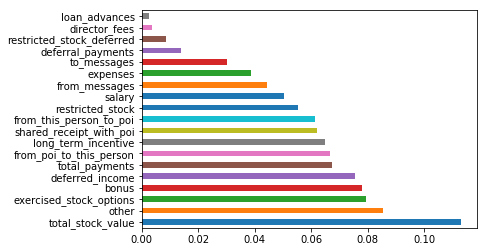

In [104]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(19).plot(kind='barh')
plt.show()

In [123]:
list(feat_importances.nlargest(19).index)

['total_stock_value',
 'other',
 'exercised_stock_options',
 'bonus',
 'deferred_income',
 'total_payments',
 'from_poi_to_this_person',
 'long_term_incentive',
 'shared_receipt_with_poi',
 'from_this_person_to_poi',
 'restricted_stock',
 'salary',
 'from_messages',
 'expenses',
 'to_messages',
 'deferral_payments',
 'restricted_stock_deferred',
 'director_fees',
 'loan_advances']

Como podemos ver no gráfico, 3 parâmetros apresentam pouca influência no modelo, e serão então removidos da análise ('loan_advances', 'director_fees', 'deferral_payments'). 
Podemos avaliar esta relação entre parâmetros e por uma matrix de Heatmap.

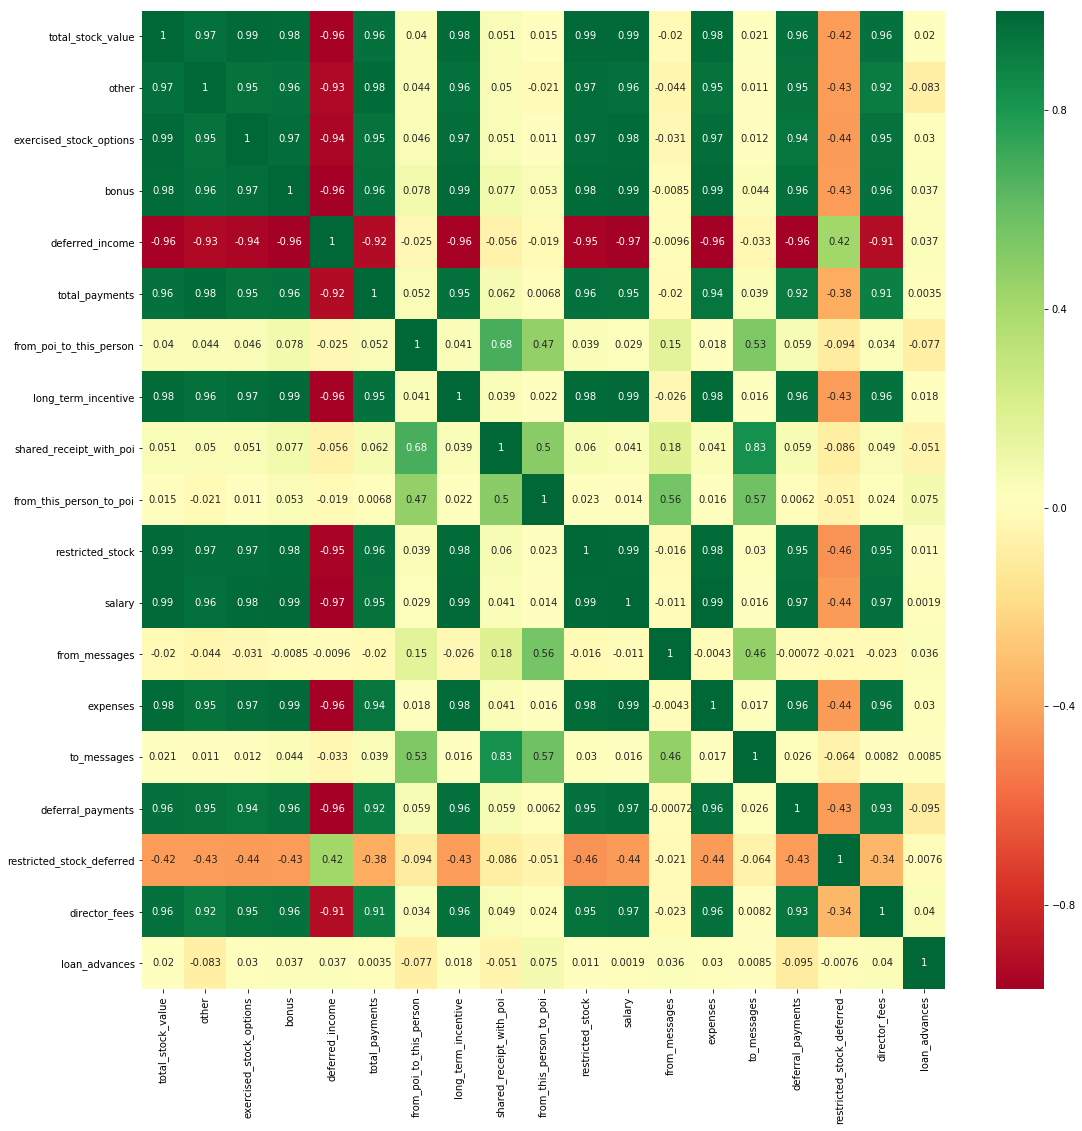

In [124]:
#get correlations of each features in dataset
corrmat = df_enron_fillna_0.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(18,18))
#plot heat map
g=sns.heatmap(df_enron_fillna_0[list(feat_importances.nlargest(19).index)].corr(
              ),annot=True,cmap="RdYlGn")

Desta forma selecionamos selecionamos os parâmetros que iremos utilizar para os testes iniciais.

In [125]:
features_list = ['deferred_income',
                 'expenses',
                 'exercised_stock_options',
                 'restricted_stock',
                 'from_this_person_to_poi',
                 'salary',
                 'total_stock_value',
                 'bonus',
                 'shared_receipt_with_poi',
                 'other',
                 'from_poi_to_this_person',
                 'long_term_incentive',
                 'total_payments',
                 'from_messages',
                 'to_messages',
                 'deferral_payments'] 

In [126]:
df_features = df_enron_fillna_0[features_list + ['poi']]

In [127]:
df_features.head(20)

,deferred_income,expenses,exercised_stock_options,restricted_stock,from_this_person_to_poi,salary,total_stock_value,bonus,shared_receipt_with_poi,other,from_poi_to_this_person,long_term_incentive,total_payments,from_messages,to_messages,deferral_payments,poi
BELDEN TIMOTHY N,-2.334434e+06,17355.0,9.531360e+05,1.575690e+05,108.000000,2.139990e+05,1110705.0,5.249999e+06,5521.0,2.106980e+05,228.000000,1.204862e+06,5501630.0,484.000000,7991.000000,2144013.0,True
BOWEN JR RAYMOND M,-8.330000e+02,65907.0,1.046379e+07,2.520550e+05,15.000000,2.786010e+05,252055.0,1.350000e+06,1593.0,1.621000e+03,140.000000,9.742930e+05,2669589.0,27.000000,1858.000000,519894.2,True
CALGER CHRISTOPHER F,-2.625000e+05,35818.0,1.046379e+07,1.260270e+05,25.000000,2.401890e+05,126027.0,1.250000e+06,2188.0,4.860000e+02,199.000000,3.753040e+05,1639297.0,144.000000,2598.000000,519894.2,True
CAUSEY RICHARD A,-2.350000e+05,30674.0,1.046379e+07,2.502063e+06,12.000000,4.151890e+05,2502063.0,1.000000e+06,1585.0,3.078950e+05,58.000000,3.500000e+05,1868758.0,49.000000,1892.000000,519894.2,True
COLWELL WESLEY,-1.440620e+05,16514.0,1.046379e+07,6.982420e+05,11.000000,2.885420e+05,698242.0,1.200000e+06,1132.0,1.017400e+05,240.000000,1.204862e+06,1490344.0,40.000000,1758.000000,27610.0,True
DELAINEY DAVID W,-1.035313e+06,86174.0,2.291113e+06,1.323148e+06,609.000000,3.651630e+05,3614261.0,3.000000e+06,2097.0,1.661000e+03,66.000000,1.294981e+06,4747979.0,3069.000000,3093.000000,519894.2,True
FASTOW ANDREW S,-1.386055e+06,55921.0,1.046379e+07,1.794412e+06,66.714286,4.406980e+05,1794412.0,1.300000e+06,1783.0,2.774640e+05,97.785714,1.736055e+06,2424083.0,300.357143,2417.142857,519894.2,True
GLISAN JR BEN F,-1.035313e+06,125978.0,3.847280e+05,3.938180e+05,6.000000,2.749750e+05,778546.0,6.000000e+05,874.0,2.003080e+05,52.000000,7.102300e+04,1272284.0,16.000000,873.000000,519894.2,True
HANNON KEVIN P,-3.117011e+06,34039.0,5.538001e+06,8.530640e+05,21.000000,2.432930e+05,6391065.0,1.500000e+06,1035.0,1.135000e+04,32.000000,1.617011e+06,288682.0,32.000000,1045.000000,519894.2,True
HIRKO JOSEPH,-1.035313e+06,77978.0,3.076606e+07,2.318621e+06,66.714286,3.834449e+05,30766064.0,2.075000e+06,1783.0,2.856000e+03,97.785714,1.204862e+06,91093.0,300.357143,2417.142857,10259.0,True


In [131]:
df_features.poi

BELDEN TIMOTHY N                  True
BOWEN JR RAYMOND M                True
CALGER CHRISTOPHER F              True
CAUSEY RICHARD A                  True
COLWELL WESLEY                    True
DELAINEY DAVID W                  True
FASTOW ANDREW S                   True
GLISAN JR BEN F                   True
HANNON KEVIN P                    True
HIRKO JOSEPH                      True
KOENIG MARK E                     True
KOPPER MICHAEL J                  True
LAY KENNETH L                     True
RICE KENNETH D                    True
RIEKER PAULA H                    True
SHELBY REX                        True
SKILLING JEFFREY K                True
YEAGER F SCOTT                    True
ALLEN PHILLIP K                  False
BADUM JAMES P                    False
BANNANTINE JAMES M               False
BAXTER JOHN C                    False
BAY FRANKLIN R                   False
BAZELIDES PHILIP J               False
BECK SALLY W                     False
BELFER ROBERT            

## Checar a relação entre as classes de poi para ver o desequilíbrio entre as classes

In [132]:
poi_class = df_features['poi'].value_counts()
print(poi_class / df_features.shape[0])

False    0.876712
True     0.123288
Name: poi, dtype: float64


Como podemos ver temos um desequilíbrio entre os indivíduos poi e não poi. Para tornar a relação entre as duas classes mais balanceada podemos utilizar uma abordagem de SMOTE (Synthetic Minority Over-sampling Technique) de geração de novas amostras sintéticas.

In [133]:
# Definir X e y
# Rescalonamento de valores usando MinMaxScaler do scikit learn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(df_features.drop('poi', axis=1))
y = df_features.poi

In [134]:
from imblearn.over_sampling import SMOTE
# Define the resampling method
method = SMOTE(kind='regular')

# Create the resampled feature set
X_resampled, y_resampled = method.fit_sample(X, y)


In [135]:
from sklearn.utils import shuffle
X_resampled,  y_resampled= shuffle(X_resampled,  y_resampled)

In [136]:
y_resampled

array([ True, False,  True, False,  True, False,  True,  True,  True,
        True, False, False,  True, False,  True, False,  True, False,
       False,  True, False,  True,  True, False, False, False,  True,
       False, False,  True,  True, False,  True,  True, False,  True,
       False, False,  True, False,  True,  True, False,  True, False,
       False,  True, False,  True,  True, False,  True, False, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False, False, False,  True, False, False, False, False,  True,
       False,  True,  True, False,  True, False, False,  True, False,
       False,  True, False, False,  True,  True,  True, False, False,
       False,  True,  True, False, False, False,  True,  True, False,
        True,  True,  True, False,  True, False,  True,  True, False,
        True,  True, False,  True,  True, False, False,  True,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,

In [141]:
from sklearn.model_selection import train_test_split
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X_resampled,  y_resampled, test_size=0.5, 
                                                    random_state=0)

from sklearn.linear_model import LogisticRegression
# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [142]:
# Métricas de avaliação do algoritmo
# Import the packages to get the different performance metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Predict probabilities
probs = clf.predict_proba(X_test)

In [143]:
# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.7231638418079096
              precision    recall  f1-score   support

       False       0.62      0.56      0.59        59
        True       0.65      0.71      0.68        69

   micro avg       0.64      0.64      0.64       128
   macro avg       0.64      0.63      0.63       128
weighted avg       0.64      0.64      0.64       128

[[33 26]
 [20 49]]


In [65]:
# This is the pipeline module we need for this from imblearn
from imblearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression

# Define which resampling method and which ML model to use in the pipeline
resampling = SMOTE(kind='borderline2')
model = LogisticRegression()
# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

In [59]:
# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


NameError: name 'classification_report' is not defined

In [ ]:
sns.pairplot(df_enron, hue='poi')

ValueError: array must not contain infs or NaNs

Agora podemos observar que existe uma série de valores faltantes nas colunas.
Para contornar esse problema, iremos separar o DataFrame em dois novos baseado na coluna `poi`.

In [28]:
df_enron_poi = df_enron_nan[df_enron_nan.poi == True]
df_enron_non_poi = df_enron_nan[df_enron_nan.poi == False]

In [29]:
df_enron_poi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, BELDEN TIMOTHY N to YEAGER F SCOTT
Data columns (total 20 columns):
salary                       17 non-null float64
to_messages                  14 non-null float64
deferral_payments            5 non-null float64
total_payments               18 non-null float64
loan_advances                1 non-null float64
bonus                        16 non-null float64
restricted_stock_deferred    0 non-null float64
deferred_income              11 non-null float64
total_stock_value            18 non-null float64
expenses                     18 non-null float64
from_poi_to_this_person      14 non-null float64
exercised_stock_options      12 non-null float64
from_messages                14 non-null float64
other                        18 non-null float64
from_this_person_to_poi      14 non-null float64
poi                          18 non-null bool
long_term_incentive          12 non-null float64
shared_receipt_with_poi      14 non-null float64

In [30]:
df_enron_non_poi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 20 columns):
salary                       78 non-null float64
to_messages                  72 non-null float64
deferral_payments            34 non-null float64
total_payments               107 non-null float64
loan_advances                3 non-null float64
bonus                        66 non-null float64
restricted_stock_deferred    18 non-null float64
deferred_income              38 non-null float64
total_stock_value            108 non-null float64
expenses                     77 non-null float64
from_poi_to_this_person      72 non-null float64
exercised_stock_options      90 non-null float64
from_messages                72 non-null float64
other                        75 non-null float64
from_this_person_to_poi      72 non-null float64
poi                          128 non-null bool
long_term_incentive          54 non-null float64
shared_receipt_with_poi      72 non-null float64

Podemos ter uma melhor distribuição dos dados usando a função `describe` nos Dataframes.

In [33]:
df_enron_poi.describe()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,1.700000e+01,14.000000,5.000000e+00,1.800000e+01,1.0,1.600000e+01,0.0,1.100000e+01,1.800000e+01,18.000000,14.000000,1.200000e+01,14.000000,1.800000e+01,14.000000,1.200000e+01,14.000000,1.700000e+01,0.0
mean,3.834449e+05,2417.142857,5.198942e+05,7.913590e+06,81525000.0,2.075000e+06,NaN,-1.035313e+06,9.165671e+06,59873.833333,97.785714,1.046379e+07,300.357143,8.029974e+05,66.714286,1.204862e+06,1783.000000,2.318621e+06,NaN
std,2.783597e+05,1961.858101,9.128895e+05,2.396549e+07,NaN,2.047437e+06,NaN,1.334972e+06,1.384117e+07,37524.658812,76.058862,1.238259e+07,805.844574,2.417568e+06,158.289622,9.916583e+05,1264.996625,3.620811e+06,NaN
min,1.584030e+05,225.000000,1.025900e+04,9.109300e+04,81525000.0,2.000000e+05,NaN,-3.504386e+06,1.260270e+05,16514.000000,13.000000,3.847280e+05,16.000000,4.860000e+02,4.000000,7.102300e+04,91.000000,1.260270e+05,NaN
25%,2.401890e+05,1115.750000,2.761000e+04,1.142396e+06,81525000.0,7.750000e+05,NaN,-1.860244e+06,1.016450e+06,31323.250000,44.500000,1.456581e+06,33.000000,4.979500e+03,12.500000,3.689780e+05,1059.250000,3.938180e+05,NaN
50%,2.786010e+05,1875.000000,2.029110e+05,1.754028e+06,81525000.0,1.275000e+06,NaN,-2.625000e+05,2.206836e+06,50448.500000,62.000000,3.914557e+06,44.500000,1.492040e+05,15.500000,1.134637e+06,1589.000000,9.850320e+05,NaN
75%,4.151890e+05,2969.250000,2.146780e+05,2.665345e+06,81525000.0,2.062500e+06,NaN,-1.220310e+05,1.051133e+07,84125.000000,135.750000,1.938604e+07,101.500000,2.607725e+05,28.750000,1.646772e+06,2165.250000,2.502063e+06,NaN
max,1.111258e+06,7991.000000,2.144013e+06,1.035598e+08,81525000.0,7.000000e+06,NaN,-8.330000e+02,4.911008e+07,127017.000000,240.000000,3.434838e+07,3069.000000,1.035973e+07,609.000000,3.600000e+06,5521.000000,1.476169e+07,NaN


In [32]:
df_enron_non_poi.describe()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,7.800000e+01,72.000000,3.400000e+01,1.070000e+02,3.000000e+00,6.600000e+01,1.800000e+01,3.800000e+01,1.080000e+02,7.700000e+01,72.000000,9.000000e+01,72.000000,7.500000e+01,72.000000,5.400000e+01,72.000000,9.300000e+01,1.700000e+01
mean,6.011525e+05,2007.111111,1.807789e+06,4.605105e+06,2.877500e+07,2.446776e+06,1.664106e+05,-1.170917e+06,6.375339e+06,1.201496e+05,58.500000,5.390155e+06,668.763889,9.469212e+05,36.277778,1.529361e+06,1058.527778,2.322312e+06,1.668049e+05
std,2.997169e+06,2693.165955,5.510228e+06,2.990485e+07,4.776800e+07,1.191776e+07,4.201494e+06,4.531597e+06,4.173084e+07,5.925085e+05,87.995198,3.275556e+07,1978.997801,4.983723e+06,85.139690,6.564217e+06,1132.503757,1.354194e+07,3.198914e+05
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,4.000000e+05,7.000000e+04,-7.576788e+06,-2.799289e+07,-4.409300e+04,1.480000e+02,0.000000,3.285000e+03,12.000000,2.000000e+00,0.000000,6.922300e+04,2.000000,-2.604490e+06,3.285000e+03
25%,2.072158e+05,513.750000,8.746875e+04,3.410185e+05,1.200000e+06,4.000000e+05,-3.896218e+05,-5.812438e+05,4.282172e+05,1.883400e+04,10.000000,4.507585e+05,20.500000,9.595000e+02,0.000000,2.608932e+05,191.500000,2.130630e+05,9.878400e+04
50%,2.545700e+05,944.000000,3.825325e+05,1.057548e+06,2.000000e+06,7.250000e+05,-1.469750e+05,-1.231420e+05,1.032338e+06,4.614500e+04,26.500000,1.043324e+06,41.000000,2.555300e+04,6.000000,3.954805e+05,594.000000,4.176190e+05,1.085790e+05
75%,3.002298e+05,2590.750000,1.066354e+06,2.031214e+06,4.296250e+07,1.000000e+06,-7.500975e+04,-3.708600e+04,2.372703e+06,7.855200e+04,61.750000,2.204999e+06,216.500000,3.876305e+05,23.250000,6.948620e+05,1635.500000,9.340650e+05,1.137840e+05
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,8.392500e+07,9.734362e+07,1.545629e+07,-1.042000e+03,4.345095e+08,5.235198e+06,528.000000,3.117640e+08,14368.000000,4.266759e+07,411.000000,4.852193e+07,4527.000000,1.303223e+08,1.398517e+06


Como os dados não tem uma distribuição homogênea, iremos usar a mediana de cada coluna para completar os valores faltantes.

In [46]:
df_enron_poi_median = df_enron_poi.fillna(df_enron_poi.median())
df_enron_non_poi_median = df_enron_non_poi.fillna(df_enron_non_poi.median())

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [47]:
df_enron_poi_median.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, BELDEN TIMOTHY N to YEAGER F SCOTT
Data columns (total 20 columns):
salary                       18 non-null float64
to_messages                  18 non-null float64
deferral_payments            18 non-null float64
total_payments               18 non-null float64
loan_advances                18 non-null float64
bonus                        18 non-null float64
restricted_stock_deferred    0 non-null float64
deferred_income              18 non-null float64
total_stock_value            18 non-null float64
expenses                     18 non-null float64
from_poi_to_this_person      18 non-null float64
exercised_stock_options      18 non-null float64
from_messages                18 non-null float64
other                        18 non-null float64
from_this_person_to_poi      18 non-null float64
poi                          18 non-null bool
long_term_incentive          18 non-null float64
shared_receipt_with_poi      18 non-null float

In [32]:
df_enron_poi.sample(10)

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
LAY KENNETH L,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,NaN,49110078.0,...,81525000.0,36.0,10359729.0,16.0,True,NaN,-300000.0,3600000.0,kenneth.lay@enron.com,123.0
CALGER CHRISTOPHER F,240189.0,2598.0,NaN,1639297.0,NaN,1250000.0,126027.0,2188.0,NaN,126027.0,...,NaN,144.0,486.0,25.0,True,NaN,-262500.0,375304.0,christopher.calger@enron.com,199.0
HIRKO JOSEPH,NaN,NaN,10259.0,91093.0,30766064.0,NaN,NaN,NaN,NaN,30766064.0,...,NaN,NaN,2856.0,NaN,True,NaN,NaN,NaN,joe.hirko@enron.com,NaN
YEAGER F SCOTT,158403.0,NaN,NaN,360300.0,8308552.0,NaN,3576206.0,NaN,NaN,11884758.0,...,NaN,NaN,147950.0,NaN,True,NaN,NaN,NaN,scott.yeager@enron.com,NaN
SHELBY REX,211844.0,225.0,NaN,2003885.0,1624396.0,200000.0,869220.0,91.0,NaN,2493616.0,...,NaN,39.0,1573324.0,14.0,True,NaN,-4167.0,NaN,rex.shelby@enron.com,13.0
SKILLING JEFFREY K,1111258.0,3627.0,NaN,8682716.0,19250000.0,5600000.0,6843672.0,2042.0,NaN,26093672.0,...,NaN,108.0,22122.0,30.0,True,NaN,NaN,1920000.0,jeff.skilling@enron.com,88.0
RIEKER PAULA H,249201.0,1328.0,214678.0,1099100.0,1635238.0,700000.0,283649.0,1258.0,NaN,1918887.0,...,NaN,82.0,1950.0,48.0,True,NaN,-100000.0,NaN,paula.rieker@enron.com,35.0
DELAINEY DAVID W,365163.0,3093.0,NaN,4747979.0,2291113.0,3000000.0,1323148.0,2097.0,NaN,3614261.0,...,NaN,3069.0,1661.0,609.0,True,NaN,NaN,1294981.0,david.delainey@enron.com,66.0
COLWELL WESLEY,288542.0,1758.0,27610.0,1490344.0,NaN,1200000.0,698242.0,1132.0,NaN,698242.0,...,NaN,40.0,101740.0,11.0,True,NaN,-144062.0,NaN,wes.colwell@enron.com,240.0
RICE KENNETH D,420636.0,905.0,NaN,505050.0,19794175.0,1750000.0,2748364.0,864.0,NaN,22542539.0,...,NaN,18.0,174839.0,4.0,True,NaN,-3504386.0,1617011.0,ken.rice@enron.com,42.0


In [64]:
df_enron_preprocessed = pd.concat([df_enron_poi, df_enron_poi, 
                                   df_enron_poi, df_enron_poi,
                                   df_enron_poi, df_enron_poi,
                                   df_enron_non_poi])

In [65]:
from sklearn.utils import shuffle
df_enron_preprocessed = shuffle(df_enron_preprocessed)

In [68]:
df_enron_preprocessed.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
REYNOLDS LAWRENCE,76399.0,NaN,51365.0,394475.0,NaN,100000.0,-140264.0,-200000.0,4221891.0,8409.0,NaN,4160672.0,NaN,202052.0,NaN,False,156250.0,NaN,201483.0,NaN
MURRAY JULIA H,229284.0,2192.0,NaN,812194.0,NaN,400000.0,NaN,NaN,597461.0,57580.0,11.0,400478.0,45.0,330.0,2.0,False,125000.0,395.0,196983.0,NaN
MULLER MARK S,251654.0,136.0,842924.0,3202070.0,NaN,1100000.0,NaN,-719000.0,1416848.0,NaN,12.0,1056320.0,16.0,947.0,0.0,False,1725545.0,114.0,360528.0,NaN
SHELBY REX,211844.0,225.0,NaN,2003885.0,NaN,200000.0,NaN,-4167.0,2493616.0,22884.0,13.0,1624396.0,39.0,1573324.0,14.0,True,NaN,91.0,869220.0,NaN
YEAGER F SCOTT,158403.0,NaN,NaN,360300.0,NaN,NaN,NaN,NaN,11884758.0,53947.0,NaN,8308552.0,NaN,147950.0,NaN,True,NaN,NaN,3576206.0,NaN


In [69]:
X = df_enron_preprocessed.drop(['poi'], axis=1).values
y = df_enron_preprocessed['poi'].values

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
imputer = Imputer()
y_imputed = imputer.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [74]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf.fit(X_train, y_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#

### Detecção de Outliers

In [20]:
sns.boxplot(x="variable", y="value", data=df_enron.melt(df_enron))

ValueError: min() arg is an empty sequence

[None]

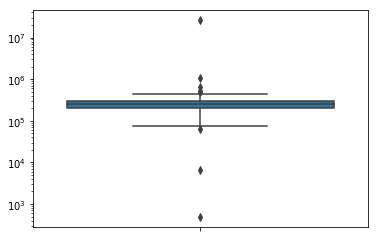

In [33]:
#
import seaborn as sns
plot = sns.boxplot(x=df_enron_nonpoi[['salary']], orient='v', )
plot.set(yscale="log")

In [31]:
#
df_enron_poi = df_enron[df_enron.poi == True]
df_enron_nonpoi = df_enron[df_enron.poi == False]

In [ ]:
# Redução de dimensões usando PCA

In [29]:
list_features = list(df_enron.columns)

In [30]:
list_features.remove('poi')
list_features.remove('email_address')

In [36]:
df_enron_poi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, BELDEN TIMOTHY N to YEAGER F SCOTT
Data columns (total 21 columns):
salary                       17 non-null float64
to_messages                  14 non-null float64
deferral_payments            5 non-null float64
total_payments               18 non-null float64
loan_advances                1 non-null float64
bonus                        16 non-null float64
email_address                18 non-null object
restricted_stock_deferred    0 non-null float64
deferred_income              11 non-null float64
total_stock_value            18 non-null float64
expenses                     18 non-null float64
from_poi_to_this_person      14 non-null float64
exercised_stock_options      12 non-null float64
from_messages                14 non-null float64
other                        18 non-null float64
from_this_person_to_poi      14 non-null float64
poi                          18 non-null bool
long_term_incentive          12 non-null float64


In [42]:
df_features_nonan = df_features.fillna(df_features.mean())

In [43]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df_features_nonan))
print(z)


[[1.65277903e-01 4.20239001e-01 4.65942418e-01 ... 2.56413706e-01
  2.02999224e-01 2.74829919e-16]
 [5.34113867e-17 0.00000000e+00 5.55805524e-01 ... 0.00000000e+00
  0.00000000e+00 2.74829919e-16]
 [2.57716074e-01 7.65163054e-01 0.00000000e+00 ... 7.91331031e-01
  5.21606867e-02 2.74829919e-16]
 ...
 [5.34113867e-17 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.74829919e-16]
 [1.85259575e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.15978392e-01 2.74829919e-16]
 [5.34113867e-17 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.74829919e-16]]


In [45]:
threshold = 3
print(np.where(z > 3))

(array([  6,   7,   7,  11,  31,  34,  47,  72,  73,  73,  73,  75,  78,
        78,  78,  79,  79, 105, 117, 117, 130, 130, 130, 130, 130, 130,
       130, 130, 130, 130, 130, 130, 130, 130, 139]), array([14,  1, 16,  6, 14, 10,  4, 12,  1, 12, 14,  1, 10, 14, 16,  3,  4,
        4,  1, 16,  0,  2,  3,  4,  5,  6,  7,  8,  9, 11, 13, 15, 17, 18,
       16]))


In [46]:
df_enron_outliers = df_features_nonan[(z < 3).all(axis=1)]

In [50]:
df_features_nonan.shape

(146, 19)

In [49]:
df_enron_outliers.shape

(131, 19)

In [20]:
df_enron.columns

Index(['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'loan_advances', 'bonus', 'email_address', 'restricted_stock_deferred',
       'deferred_income', 'total_stock_value', 'expenses',
       'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
       'other', 'from_this_person_to_poi', 'poi', 'long_term_incentive',
       'shared_receipt_with_poi', 'restricted_stock', 'director_fees'],
      dtype='object')

## Etapa de teste de modelos

In [13]:
df_zero = df_enron_nan.fillna(0)

In [15]:
df_zero.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 20 columns):
salary                       146 non-null float64
to_messages                  146 non-null float64
deferral_payments            146 non-null float64
total_payments               146 non-null float64
exercised_stock_options      146 non-null float64
bonus                        146 non-null float64
restricted_stock             146 non-null float64
shared_receipt_with_poi      146 non-null float64
restricted_stock_deferred    146 non-null float64
total_stock_value            146 non-null float64
expenses                     146 non-null float64
loan_advances                146 non-null float64
from_messages                146 non-null float64
other                        146 non-null float64
from_this_person_to_poi      146 non-null float64
poi                          146 non-null bool
director_fees                146 non-null float64
deferred_income              146 

In [25]:
# Dividindo os dados em treinamento e testagem
from sklearn.model_selection import train_test_split

In [19]:
df_zero.columns

Index([u'salary', u'to_messages', u'deferral_payments', u'total_payments',
       u'exercised_stock_options', u'bonus', u'restricted_stock',
       u'shared_receipt_with_poi', u'restricted_stock_deferred',
       u'total_stock_value', u'expenses', u'loan_advances', u'from_messages',
       u'other', u'from_this_person_to_poi', u'poi', u'director_fees',
       u'deferred_income', u'long_term_incentive', u'from_poi_to_this_person'],
      dtype='object')

In [23]:
X = df_zero.drop(['poi'], axis=1).values
y = df_zero['poi'].values

In [24]:
y

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True, False,  True, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False, False,

In [84]:
X_fillna = df_enron_outliers.fillna(df_enron_outliers.mean()).values
y_fillna = df_enron.loc[df_enron_outliers.index]['poi'].values

In [76]:
len(y_fillna_mean)
len(X_fillna_mean)

131

In [98]:
# Rescalonamento de valores usando MinMaxScaler do scikit learn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_fillna_scaled = scaler.fit_transform(X_fillna)


In [99]:
X_fillna_scaled

array([[0.18138409, 0.71988866, 0.91895058, ..., 0.52621723, 0.00677304,
        1.        ],
       [0.50569581, 0.51033919, 0.08702804, ..., 0.43987458, 0.16571445,
        1.        ],
       [0.        , 0.12879555, 0.53957326, ..., 0.17340824, 0.12487443,
        1.        ],
       ...,
       [0.50569581, 0.51033919, 0.53957326, ..., 0.43987458, 0.16571445,
        1.        ],
       [0.14217564, 0.51033919, 0.53957326, ..., 0.43987458, 0.25652154,
        1.        ],
       [0.50569581, 0.51033919, 0.53957326, ..., 0.43987458, 0.16571445,
        1.        ]])

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.5, random_state=42)


In [27]:
# Teste inicial com Regressão Logística (Mean)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [28]:
# Evaluate score for Logistic Regression
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.80821917808219179

In [103]:
# Regressão Logística para fillna median
# Teste inicial com Regressão Logística (Mean)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')
clf.fit(X_train, y_train)
pred_dt = clf.predict(X_test)


from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred_dt)


0.9090909090909091

In [29]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=2, min_samples_leaf=3)
clf_gini.fit(X_train, y_train)
pred_dt = clf_gini.predict(X_test)

In [30]:
accuracy_score(y_test, pred_dt)

0.83561643835616439

In [69]:
df_enron.fillna(0, inplace=True)

In [70]:
df_enron.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null float64
to_messages                  146 non-null float64
deferral_payments            146 non-null float64
total_payments               146 non-null float64
exercised_stock_options      146 non-null float64
bonus                        146 non-null float64
restricted_stock             146 non-null float64
shared_receipt_with_poi      146 non-null float64
restricted_stock_deferred    146 non-null float64
total_stock_value            146 non-null float64
expenses                     146 non-null float64
loan_advances                146 non-null float64
from_messages                146 non-null float64
other                        146 non-null float64
from_this_person_to_poi      146 non-null float64
poi                          146 non-null bool
director_fees                146 non-null float64
deferred_income              146 

In [71]:
df_enron

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,0.0,2195.0,152.0,65.0,False,0.0,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BADUM JAMES P,0.0,0.0,178980.0,182466.0,257817.0,0.0,0.0,0.0,0.0,257817.0,...,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0,0.0
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,...,0.0,29.0,864523.0,0.0,False,0.0,-5104.0,0.0,james.bannantine@enron.com,39.0
BAXTER JOHN C,267102.0,0.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,0.0,0.0,10623258.0,...,0.0,0.0,2660303.0,0.0,False,0.0,-1386055.0,1586055.0,0,0.0
BAY FRANKLIN R,239671.0,0.0,260455.0,827696.0,0.0,400000.0,145796.0,0.0,-82782.0,63014.0,...,0.0,0.0,69.0,0.0,False,0.0,-201641.0,0.0,frank.bay@enron.com,0.0
BAZELIDES PHILIP J,80818.0,0.0,684694.0,860136.0,1599641.0,0.0,0.0,0.0,0.0,1599641.0,...,0.0,0.0,874.0,0.0,False,0.0,0.0,93750.0,0,0.0
BECK SALLY W,231330.0,7315.0,0.0,969068.0,0.0,700000.0,126027.0,2639.0,0.0,126027.0,...,0.0,4343.0,566.0,386.0,False,0.0,0.0,0.0,sally.beck@enron.com,144.0
BELDEN TIMOTHY N,213999.0,7991.0,2144013.0,5501630.0,953136.0,5249999.0,157569.0,5521.0,0.0,1110705.0,...,0.0,484.0,210698.0,108.0,True,0.0,-2334434.0,0.0,tim.belden@enron.com,228.0
BELFER ROBERT,0.0,0.0,-102500.0,102500.0,3285.0,0.0,0.0,0.0,44093.0,-44093.0,...,0.0,0.0,0.0,0.0,False,3285.0,0.0,0.0,0,0.0
BERBERIAN DAVID,216582.0,0.0,0.0,228474.0,1624396.0,0.0,869220.0,0.0,0.0,2493616.0,...,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,david.berberian@enron.com,0.0


In [77]:
from sklearn.preprocessing import StandardScaler
#features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
x = df_enron.loc[:, list_features].values
# Separating out the target
y = df_enron.loc[:,['poi']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [78]:
x

array([[-0.0746153 ,  0.75723808,  0.88982089, ..., -1.13847635,
        -0.08925145,  0.11913453],
       [-0.16657959, -0.55048066, -0.09510396, ...,  0.16149683,
        -0.16484433, -0.51903967],
       [-0.16636238, -0.29542594, -0.1606183 , ...,  0.15934332,
        -0.16484433,  0.01050913],
       ..., 
       [-0.16657959, -0.55048066, -0.1606183 , ...,  0.16149683,
        -0.16484433, -0.51903967],
       [-0.09444758, -0.55048066, -0.1606183 , ...,  0.16149683,
        -0.16484433, -0.51903967],
       [-0.16657959, -0.55048066, -0.1606183 , ...,  0.16149683,
        -0.16484433, -0.51903967]])

### Feature Selection Logistic regression ()

In [32]:
from sklearn.model_selection import GridSearchCV
# Specify L1 regularization
lr = LogisticRegression(penalty='l1')

# Instantiate the GridSearchCV object and run the search
searcher = GridSearchCV(lr, {'C':[0.001, 0.01, 0.1, 1, 10]})
searcher.fit(X_train, y_train)

# Report the best parameters
print("Best CV params", searcher.best_params_)

# Find the number of nonzero coefficients (selected features)
best_lr = searcher.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print("Number of selected features:", np.count_nonzero(coefs))

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


('Best CV params', {'C': 0.001})
('Total number of features:', 19)
('Number of selected features:', 15)


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [33]:
# Instantiate an RBF SVM
svm = SVC()

# Instantiate the GridSearchCV object and run the search
parameters = {'C':[0.1, 1, 10], 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, ____)
____.fit(____)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(____))

NameError: name 'SVC' is not defined

In [ ]:
# We set random_state=0 for reproducibility 
linear_classifier = SGDClassifier(random_state=0)

# Instantiate the GridSearchCV object and run the search
parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
             'loss':['hinge', 'log'], 'penalty':['l1', 'l2']}
searcher = GridSearchCV(linear_classifier, parameters, cv=10)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [80]:
principalDf

,principal component 1,principal component 2
0,0.356862,1.456886
1,-0.534703,-1.044702
2,-0.270641,-0.464044
3,0.440911,-1.034934
4,-0.363165,-1.042298
5,-0.437289,-1.043755
6,-0.534112,5.868322
7,0.202685,5.394563
8,-0.567681,-1.046743
9,-0.464150,-1.045965


In [12]:
list_features = list(df_enron.columns)

In [ ]:
df_

In [ ]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Split out only the text data
X_train, X_test, y_train, y_test = train_test_split(sample_df['text'],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=456)

# Instantiate Pipeline object: pl
pl = Pipeline([
        ('vec', CountVectorizer),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - just text data: ", accuracy)

# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Obtain the text data: get_text_data
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)

# Obtain the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[['numeric', 'with_missing']], validate=False)

# Fit and transform the text data: just_text_data
just_text_data = get_text_data.fit_transform(sample_df)

# Fit and transform the numeric data: just_numeric_data
just_numeric_data = get_numeric_data.fit_transform(sample_df)

# Print head to check results
print('Text Data')
print(just_text_data.head())
print('\nNumeric Data')
print(just_numeric_data.head())

In [ ]:
# Import FeatureUnion
from sklearn.pipeline import FeatureUnion

# Split using ALL data in sample_df
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing', 'text']],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=22)

# Create a FeatureUnion with nested pipeline: process_and_join_features
process_and_join_features = FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )

# Instantiate nested pipeline: pl
pl = Pipeline([
        ('union', process_and_join_features),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])


# Fit pl to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - all data: ", accuracy)

In [ ]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)

# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)


In [ ]:
# Complete the pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

In [34]:
# Import random forest classifer
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier())
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

NameError: name 'Pipeline' is not defined

In [3]:
# Checando chaves de cada entrada no dicionário
list(data_dict.get('ALLEN PHILLIP K').keys())

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']

In [4]:
df_enron = pd.DataFrame.from_dict(data_dict, orient='index')

In [5]:
df_enron[df_enron.poi ==True].shape

(18, 21)

In [8]:
df_enron.to_csv('df_enron.csv')


In [33]:
list(df_enron.salary)

[201955,
 'NaN',
 477,
 267102,
 239671,
 80818,
 231330,
 213999,
 'NaN',
 216582,
 187922,
 'NaN',
 213625,
 248546,
 'NaN',
 278601,
 'NaN',
 248017,
 261516,
 330546,
 240189,
 261809,
 415189,
 'NaN',
 'NaN',
 'NaN',
 288542,
 'NaN',
 314288,
 184899,
 206121,
 365163,
 492375,
 210500,
 250100,
 262788,
 221003,
 278601,
 'NaN',
 210692,
 182245,
 170941,
 304588,
 440698,
 199157,
 'NaN',
 'NaN',
 1060932,
 'NaN',
 192008,
 231946,
 'NaN',
 'NaN',
 'NaN',
 274975,
 272880,
 'NaN',
 6615,
 374125,
 243293,
 'NaN',
 'NaN',
 'NaN',
 262663,
 211788,
 'NaN',
 'NaN',
 'NaN',
 130724,
 85274,
 288558,
 'NaN',
 275101,
 404338,
 174246,
 271442,
 309946,
 224305,
 339288,
 1072321,
 273746,
 'NaN',
 'NaN',
 236457,
 'NaN',
 'NaN',
 349487,
 'NaN',
 263413,
 365038,
 'NaN',
 370448,
 'NaN',
 365788,
 'NaN',
 'NaN',
 'NaN',
 267093,
 251654,
 229284,
 'NaN',
 329078,
 94941,
 261879,
 'NaN',
 655037,
 197091,
 'NaN',
 'NaN',
 'NaN',
 96840,
 76399,
 420636,
 249201,
 'NaN',
 'NaN',
 3041

## Bibliografia
### Resampling
* https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
* https://elitedatascience.com/imbalanced-classes
* Detecção de Outliers https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
* Feature Selection https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/
* https://machinelearningmastery.com/feature-selection-machine-learning-python/
* https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e